Lab 1 ‒  Image segmentation

**Author:** Arthur BRICQ, Anne-Aimée BERNARD, Jonas ULBRICH  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

This notebook present the results that we obtained during the lab 01, and shows how to obtain them. For better understanding of the concepts, we coded several functions in Python and we call those functions in this notebook. However, the functions are not part of the Notebook but are kept inside the folder lab01_functions. Also, the pictures used during the lab are saved within the folder "data". 

In [1]:
import matplotlib.pyplot as plt
import lab01_functions as imPro
import skimage.io
import skimage.morphology
from skimage.color import rgb2gray
import numpy as np

## Part 1: Brain segmentation
In this section, we have a picture of the brain obtained after an fMRI. We want to to count the number of pixels included in the brain. In order to do so, we are going to present 3 different methods, followed by a recap of the results obtained.

### 1.1 Brain image visualization

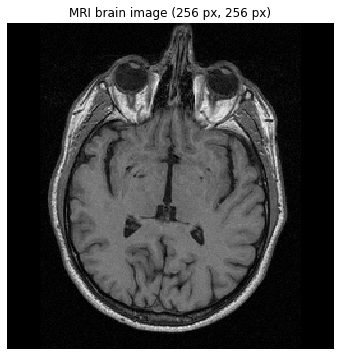

In [2]:
# Load image
brain_im = skimage.io.imread('data/lab-01-data/brain-slice40.tiff')
im_h, im_w = brain_im.shape

# Plot the image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

### 1.3 Contour detection

We can use contour detection to count the number of pixels within the brain in the picture. There must be an algorithm that finds the contour in the picture, followed by another algorithm that counts the number of pixels in a delimited region. In order to have reusable functions (for part II) we wrote a function that takes as input the edge map (obtained after contour detection) and will cluster every pixel within a closed group delimited by the boundary.

As we wanted to test the robustness of our results, we also programmed 2 different methods to find contours. One of them is using the Lagrange technique, as the other one is an heuristic way to find edges. 

#### 2 methods to find edges:

In [4]:
# 1) Laplace Method
def getEdgeMapMethod1(img, t1, t2):
    binary_im = np.logical_and(img > t1, brain_im < t2) 
    edgeMap = skimage.filters.laplace(binary_im)
    edgeMap[edgeMap>0]=-edgeMap[edgeMap>0]
    return edgeMap
   
# 2) Heuristic method
def getEdgeMapMethod2(img, t1, t2):
    sigma=2.5
    G_t1=10
    G_t2=200
    (edges,thld_img,G,Phi,G_thld_img)=imPro.skeletonize_based_sobel(img,sigma,t1,t2,G_t1,G_t2)
    edgeMap = -np.array(edges).astype(int)
    return edgeMap

The following block of code show the different steps of the usage of edge detection to count the number of pixels

In [ ]:
### 1. Get the edge map with method (1) or with method (2) 
edgeMap = getEdgeMapMethod1(brain_im,40,100)
imPro.plotEdgeMap(edgeMap)

### 2. Cluster every pixels within closed group with our algoribbthm
labels = imPro.labelizePixels(edgeMap)
imPro.plotImage(labels)

### 3. Analysis of the labels
plt.figure()
# Histogram of each label
n, bins, patches = plt.hist(labels.ravel(),bins=np.unique(labels))
# Sort the occurences in ascending order
indexes = np.argsort(n)
# The label of interest is (clearly) the second most recurent label, since the most recurrent one is the background
indexOfLabel = indexes[-2]
numberOfPixels = n[indexOfLabel] 
ratio = numberOfPixels / im_h / im_w
print("Result of the analysis")
print("- Number of pixels of the brain: {},\n- Ratio: {}".format(numberOfPixels, ratio))

Then this block of code is exactly the same as above, just using the second edge detection method (for verification of the robustness)

Result of the analysis
- Number of pixels of the brain: 14786.0,
- Ratio: 0.225616455078125


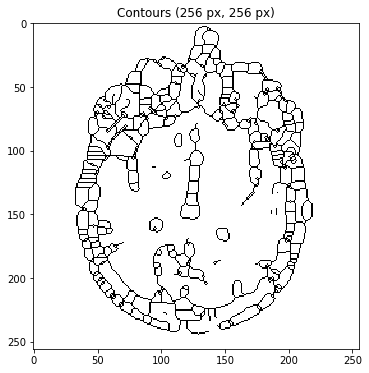

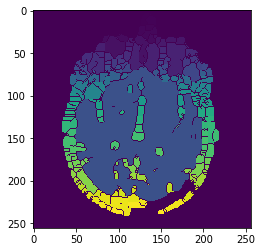

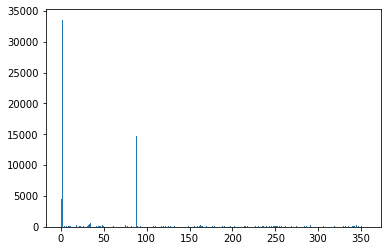

In [5]:
### 1. Get the edge map with method (1) or with method (2) 
edgeMap = getEdgeMapMethod2(brain_im,55,105)
imPro.plotEdgeMap(edgeMap)

### 2. Cluster every pixels within closed group with our algorithm
labels = imPro.labelizePixels(edgeMap)
imPro.plotImage(labels)

### 3. Analysis of the labels
plt.figure()
# Histogram of each label
n, bins, patches = plt.hist(labels.ravel(),bins=np.unique(labels))
# Sort the occurences in ascending order
indexes = np.argsort(n)
# The label of interest is (clearly) the second most recurent label, since the most recurrent one is the background
indexOfLabel = indexes[-2]
numberOfPixels = n[indexOfLabel] 
ratio = numberOfPixels / im_h / im_w
print("Result of the analysis")
print("- Number of pixels of the brain: {},\n- Ratio: {}".format(numberOfPixels, ratio))

### 1.4 Conclusion
It appeared, using our different analysis, that the number of pixel belonging to the brain is approximately XXXXXX.
Here are our results for three different methods

| Method                      | Number of Pixel | Ratio |
| --------------------------- | --------------- | ----- |
| Region growing              | ???             | ???   |
| Laplace Contour detection   | 14786           | 0.227 |
| Heuristic Contour detection | 15900           | 0.243 |


## Part 2: Shape/color segmentation

In this section, we create a routine to :

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

One specific challenge is to be robust to illumination changes.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [ ]:
# Load images
im1 = skimage.io.imread('data/lab-01-data/arena-shapes-01.png')
im2 = skimage.io.imread('data/lab-01-data/arena-shapes-02.png')
im3 = skimage.io.imread('data/lab-01-data/arena-shapes-03.png')
images = np.array([im1,im2,im3])
imPro.plotImage(im2)

### 2.2 Number of shapes of each color


The next block is taking care of counting the number of shapes of each color for the three different pictures. 

The main assumption that we do is that each shape should contains approximatively the same number of pixels. Therefore, if we find a way to group each pixels within groups of closed forms and if we can do this for each color separatly, then we are done (and only some post-processing classification is required).

In the case of the given picture, we see that this assumption is verified (each shape has the same size). There are 3 different shapes (the line, the cross and the star) that all have the same sizes and that are as follow

| Color | Line | Cross | Star |
| ----- | ---- | ----- | ---- |
| Blue | 0 | 3 | 2 |
| Black | 1 | 2 | 2 |

Therefore, this table is what we want to find at the end, and working for three different luminosities. 

The code goes throug the following logical step for each picture:
1. Separate the background from all the shapes, using optimal threshold - so that it works for every intensity.
2. Obtain the black shapes (as logical np.array), using the blue chanel to threshold all the black shapes. For this, we use the knowledge of one picture that we know of being black, extract its blue value and extend it a little bit to perform the threshold. This is done with the function ` blueThresholdForPixel(pixel, image)`.
3. Obtain the blue shapes (as logical np.array), by basically doing a substraction of all the shapes minus the black shapes. Since the contours would still be around, we then perform an opening to kill them. 
4. Count the number of pixels of each color. This parts makes use of the function `countNumberOfShapes(im_bi)`. The documentation of the function explains in the details how it works. Basically, it will call again the function `labelizePixels(edgeMap,minValue=0)` (as in part I) to give cluster every pixel inside groups, and then the function `labels2Shapes(labels)` that does the post-processing job of counting every classifying every group of N pixels to a shape.

In [ ]:
for i,im in enumerate(images):
    # 1. Seperate the background from the shapes with optimal threshold 
    tmp = im[:,:,0]
    imPro.plotImage(tmp)
    t = skimage.filters.threshold_otsu(tmp)
    im_bi = tmp < t 
    
    # 2. Obtain the black shapes
    tmp = im[:,:,2]
    tmp = skimage.filters.gaussian(tmp,sigma = 2.5) * 255
    tmp = skimage.exposure.rescale_intensity(tmp,out_range = (0,255))
    im_bi_black = imPro.blueThresholdForPixel((358,56),tmp)
    
    # 3. Obtain the blue shapes
    im_bi_blue = np.logical_xor(im_bi,im_bi_black)
    im_bi_blue = skimage.morphology.opening(im_bi_blue)
   
    # 4. Count the number of shapes for each picture
    groups_blue = imPro.countNumberOfShapes(im_bi_blue)
    groups_black = imPro.countNumberOfShapes(im_bi_black)
    
    # 5. Display the resuls 
    print("Image :",i+1)
    print("Color blue")
    print("   Number of different shapes :",len(groups_blue))
    print("   Description of shapes: ")
    for group in groups_blue:
        print("   - Number of elements:", len(group)," ; Mean number of pixel: ", np.mean(group))  
    print("Color black")
    print("   Number of different shapes :",len(groups_black))
    print("   Description of each shapes: ")
    for group in groups_black:
        print("   - Number of elements:", len(group)," ; Mean number of pixel: ", np.mean(group))
    

### 2.3 Total area (in pixels) of each color

We want to count the number of pixels for each color. One way to do this is to apply the first same steps as before to dissociate the black and blue parts of the picture, and then we perform a simple counting of non-false elements. 

In [ ]:
for i,im in enumerate(images):
    # 1. Seperate the background from the shapes with optimal threshold 
    tmp = im[:,:,0]
    imPro.plotImage(tmp)
    t = skimage.filters.threshold_otsu(tmp)
    im_bi = tmp < t 

    # 2. Obtain the black shapes
    tmp = im[:,:,2]
    tmp = skimage.filters.gaussian(tmp,sigma = 2.5) * 255
    tmp = skimage.exposure.rescale_intensity(tmp,out_range = (0,255))
    im_bi_black = imPro.blueThresholdForPixel((358,56),tmp)
    
    # 3. Obtain the blue shapes
    im_bi_blue = np.logical_xor(im_bi,im_bi_black)
    im_bi_blue = skimage.morphology.opening(im_bi_blue)

    # Count the number of pixels on each color
    n_blue = np.count_nonzero(im_bi_blue)
    n_black = np.count_nonzero(im_bi_black)
    
    print("Image :",i+1)
    print("Color blue: ", n_blue)
    print("Color black: ", n_black)
    